In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


In [ ]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])


In [ ]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


In [ ]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    #layers = upscale_block(layers)
    #layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


In [ ]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


In [ ]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [ ]:
import numpy as np 
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re

In [ ]:
IMG_SIZE=256

In [ ]:
def create_dataset():
    photos = []
    photos_labels = []

    files_list1 =sorted( os.listdir("D:/dataset/dataset/CUHK_training_cropped_photos/photos"))
    for file_name in (files_list1):
        path=("D:/dataset/dataset/CUHK_training_cropped_photos/photos"+"/" +file_name)
        img=cv2.imread(path)
      
        image=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
       
        photos.append(np.array(image))  
        photos_labels.append(file_name)
      
    
    files_list2 = sorted(os.listdir("D:/dataset/dataset/CUHK_testing_cropped_photos/photos"))
    for file_name in (files_list2):
        path=("D:/dataset/dataset/CUHK_testing_cropped_photos/photos"+"/" +file_name)
        img=cv2.imread(path)
       
        image=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
        photos.append(np.array(image))  
        photos_labels.append(file_name)
                            
    sketches= []  
    sketches_labels = []

    files_list3 =sorted( os.listdir("D:/dataset/dataset/CUHK_training_cropped_sketches/sketches"))
    for file_name in sorted(files_list3):
        path=("D:/dataset/dataset/CUHK_training_cropped_sketches/sketches"+"/" +file_name)
        img=cv2.imread(path)
     
        image2=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
        sketches.append(np.array(image2))  
        sketches_labels.append(file_name)
        
    files_list4 =sorted( os.listdir("D:/dataset/dataset/CUHK_testing_cropped_sketches/sketches"))
    for file_name in sorted(files_list4):
        path=("D:/dataset/dataset/CUHK_testing_cropped_sketches/sketches"+"/" +file_name)
        img=cv2.imread(path)

        image2=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
        sketches.append(np.array(image2))  
        sketches_labels.append(file_name)
    sketches = np.asarray(sketches)
    photos = np.asarray(photos)
    sketches_labels = np.array(sketches_labels)
    
    return photos,sketches,sketches_labels, photos_labels

In [ ]:
photos,sketches, sketches_labels,photos_labels=create_dataset()

In [ ]:
print(photos.shape)
print(sketches.shape)

(188, 256, 256, 3)
(188, 256, 256, 3)


In [ ]:
from keras.models import load_model
from numpy.random import randint
model = load_model('model_sachi_000300.h5')

C:\Users\Dell\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
dataset=sketches.astype('float32')
	# scale from [0,255] to [-1,1]
dataset = (dataset - 127.5) / 127.5

or_photos=photos.astype('float32')
	# scale from [0,255] to [-1,1]
or_photos = (or_photos - 127.5) / 127.5

In [ ]:
gen_photos=[]
   
     
        
# select random example
for i in range(len(dataset)):
  
    src_image = dataset[[i]]
    # generate image from source

    gen_image = model.predict(src_image)
    
    gen_photos.append(np.array(gen_image))
# plot all three images
gen_photos=np.array(gen_photos)

1/1 [==============================] - 0s 237ms/step


In [ ]:
gen_photos.resize(188,  256, 256, 3)

In [ ]:
gen_photos.shape

(188, 256, 256, 3)

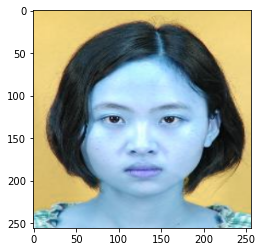

In [ ]:
plt.imshow(photos[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


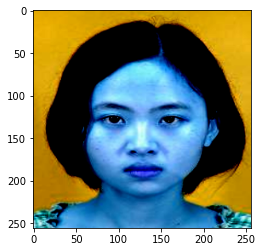

In [ ]:
plt.imshow(or_photos [10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


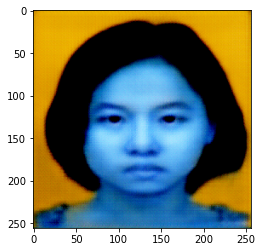

In [ ]:
plt.imshow(gen_photos [10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


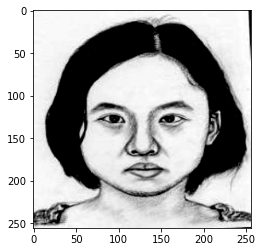

In [ ]:
plt.imshow(dataset[10])

In [ ]:
lr_train =  gen_photos[0:100]
hr_train = or_photos[0:100]


In [ ]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
print(hr_shape)
print(lr_shape)

(256, 256, 3)
(256, 256, 3)


In [ ]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [ ]:
#lr_ip=Input(shape=(128,128,3))
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_278 (Conv2D)            (None, 256, 256, 64  15616       ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 p_re_lu_93 (PReLU)             (None, 256, 256, 64  64          ['conv2d_278[0][0]']             
                                )                                                          

In [ ]:
#hr_ip = Input(shape=(128,128,3))
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_313 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu_104 (LeakyReLU)  (None, 256, 256, 64)     0         
                                                                 
 conv2d_314 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_282 (Ba  (None, 128, 128, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_105 (LeakyReLU)  (None, 128, 128, 64)     0         
                                                          

In [ ]:
vgg = build_vgg((256,256,3))
print(vgg.summary())

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0  

In [ ]:
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_23 (Functional)          (None, 256, 256, 3)  1259331     ['input_18[0][0]']               
                                                                                                  
 input_19 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                           

In [ ]:
len(lr_train)

100

In [ ]:
len(hr_train)

100

In [ ]:
epochs = 3
batch_size = 1  
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(hr_train))):
        lr_imgs = lr_train[[b]] #Fetch a batch of LR images for training
        hr_imgs = hr_train[[b]] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 3 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 467ms/step


  1%|▊                                                                                 | 1/100 [00:33<54:46, 33.20s/it]

1/1 [==============================] - 0s 300ms/step


  2%|█▋                                                                                | 2/100 [00:47<36:01, 22.06s/it]

1/1 [==============================] - 0s 315ms/step


  3%|██▍                                                                               | 3/100 [01:01<30:00, 18.56s/it]

1/1 [==============================] - 0s 273ms/step


  4%|███▎                                                                              | 4/100 [01:16<27:06, 16.94s/it]

1/1 [==============================] - 0s 299ms/step


  5%|████                                                                              | 5/100 [01:30<25:16, 15.96s/it]

1/1 [==============================] - 0s 280ms/step


  6%|████▉                                                                             | 6/100 [01:44<24:01, 15.34s/it]

1/1 [==============================] - 0s 282ms/step


  7%|█████▋                                                                            | 7/100 [01:58<23:12, 14.98s/it]

1/1 [==============================] - 0s 287ms/step


  8%|██████▌                                                                           | 8/100 [02:13<22:43, 14.82s/it]

1/1 [==============================] - 0s 312ms/step


  9%|███████▍                                                                          | 9/100 [02:27<22:15, 14.68s/it]

1/1 [==============================] - 0s 296ms/step


 10%|████████                                                                         | 10/100 [02:42<21:53, 14.59s/it]

1/1 [==============================] - 0s 309ms/step


 11%|████████▉                                                                        | 11/100 [02:56<21:23, 14.42s/it]

1/1 [==============================] - 0s 281ms/step


 12%|█████████▋                                                                       | 12/100 [03:10<21:07, 14.40s/it]

1/1 [==============================] - 0s 280ms/step


 13%|██████████▌                                                                      | 13/100 [03:25<20:59, 14.48s/it]

1/1 [==============================] - 0s 283ms/step


 14%|███████████▎                                                                     | 14/100 [03:39<20:48, 14.52s/it]

1/1 [==============================] - 0s 277ms/step


 15%|████████████▏                                                                    | 15/100 [03:54<20:39, 14.59s/it]

1/1 [==============================] - 0s 282ms/step


 16%|████████████▉                                                                    | 16/100 [04:09<20:28, 14.62s/it]

1/1 [==============================] - 0s 281ms/step


 17%|█████████████▊                                                                   | 17/100 [04:23<20:14, 14.64s/it]

1/1 [==============================] - 0s 290ms/step


 18%|██████████████▌                                                                  | 18/100 [04:38<20:00, 14.64s/it]

1/1 [==============================] - 0s 283ms/step


 19%|███████████████▍                                                                 | 19/100 [04:53<19:46, 14.65s/it]

1/1 [==============================] - 0s 286ms/step


 20%|████████████████▏                                                                | 20/100 [05:07<19:18, 14.49s/it]

1/1 [==============================] - 0s 273ms/step


 21%|█████████████████                                                                | 21/100 [05:21<18:56, 14.38s/it]

1/1 [==============================] - 0s 279ms/step


 22%|█████████████████▊                                                               | 22/100 [05:35<18:43, 14.41s/it]

1/1 [==============================] - 0s 289ms/step


 23%|██████████████████▋                                                              | 23/100 [05:50<18:33, 14.46s/it]

1/1 [==============================] - 0s 281ms/step


 24%|███████████████████▍                                                             | 24/100 [06:05<18:20, 14.48s/it]

1/1 [==============================] - 0s 309ms/step


 25%|████████████████████▎                                                            | 25/100 [06:19<18:06, 14.49s/it]

1/1 [==============================] - 0s 281ms/step


 26%|█████████████████████                                                            | 26/100 [06:34<17:55, 14.53s/it]

1/1 [==============================] - 0s 285ms/step


 27%|█████████████████████▊                                                           | 27/100 [06:49<17:56, 14.75s/it]

1/1 [==============================] - 0s 321ms/step


 28%|██████████████████████▋                                                          | 28/100 [07:05<18:05, 15.08s/it]

1/1 [==============================] - 0s 287ms/step


 29%|███████████████████████▍                                                         | 29/100 [07:20<17:44, 15.00s/it]

1/1 [==============================] - 0s 278ms/step


 30%|████████████████████████▎                                                        | 30/100 [07:34<17:26, 14.95s/it]

1/1 [==============================] - 0s 276ms/step


 31%|█████████████████████████                                                        | 31/100 [07:49<17:07, 14.89s/it]

1/1 [==============================] - 0s 280ms/step


 32%|█████████████████████████▉                                                       | 32/100 [08:04<16:49, 14.85s/it]

1/1 [==============================] - 0s 284ms/step


 33%|██████████████████████████▋                                                      | 33/100 [08:19<16:32, 14.82s/it]

1/1 [==============================] - 0s 286ms/step


 34%|███████████████████████████▌                                                     | 34/100 [08:33<16:14, 14.77s/it]

1/1 [==============================] - 0s 291ms/step


 35%|████████████████████████████▎                                                    | 35/100 [08:48<15:56, 14.72s/it]

1/1 [==============================] - 0s 291ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [09:03<15:43, 14.75s/it]

1/1 [==============================] - 0s 281ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [09:17<15:25, 14.69s/it]

1/1 [==============================] - 0s 284ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [09:32<15:09, 14.68s/it]

1/1 [==============================] - 0s 286ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [09:46<14:44, 14.50s/it]

1/1 [==============================] - 0s 272ms/step


 40%|████████████████████████████████▍                                                | 40/100 [10:00<14:25, 14.43s/it]

1/1 [==============================] - 0s 278ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [10:15<14:11, 14.44s/it]

1/1 [==============================] - 0s 277ms/step


 42%|██████████████████████████████████                                               | 42/100 [10:29<14:02, 14.52s/it]

1/1 [==============================] - 0s 283ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [10:44<13:52, 14.60s/it]

1/1 [==============================] - 0s 284ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [10:59<13:38, 14.61s/it]

1/1 [==============================] - 0s 278ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [11:14<13:26, 14.66s/it]

1/1 [==============================] - 0s 286ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [11:28<13:09, 14.62s/it]

1/1 [==============================] - 0s 267ms/step


 47%|██████████████████████████████████████                                           | 47/100 [11:42<12:47, 14.49s/it]

1/1 [==============================] - 0s 288ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [11:57<12:30, 14.44s/it]

1/1 [==============================] - 0s 271ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [12:11<12:11, 14.34s/it]

1/1 [==============================] - 0s 270ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [12:25<11:55, 14.32s/it]

1/1 [==============================] - 0s 271ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [12:39<11:39, 14.27s/it]

1/1 [==============================] - 0s 286ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [12:53<11:22, 14.23s/it]

1/1 [==============================] - 0s 287ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [13:07<11:05, 14.15s/it]

1/1 [==============================] - 0s 298ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [13:22<10:51, 14.16s/it]

1/1 [==============================] - 0s 282ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [13:36<10:37, 14.16s/it]

1/1 [==============================] - 0s 292ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [13:50<10:25, 14.21s/it]

1/1 [==============================] - 0s 285ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [14:04<10:12, 14.24s/it]

1/1 [==============================] - 0s 289ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [14:19<09:57, 14.24s/it]

1/1 [==============================] - 0s 289ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [14:33<09:44, 14.27s/it]

1/1 [==============================] - 0s 295ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [14:47<09:28, 14.21s/it]

1/1 [==============================] - 0s 293ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [15:01<09:15, 14.24s/it]

1/1 [==============================] - 0s 270ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [15:15<08:57, 14.14s/it]

1/1 [==============================] - 0s 288ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [15:29<08:41, 14.10s/it]

1/1 [==============================] - 0s 301ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [15:43<08:24, 14.01s/it]

1/1 [==============================] - 0s 270ms/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [15:58<08:15, 14.16s/it]

1/1 [==============================] - 0s 276ms/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [16:12<08:02, 14.18s/it]

1/1 [==============================] - 0s 283ms/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [16:26<07:49, 14.23s/it]

1/1 [==============================] - 0s 279ms/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [16:40<07:33, 14.16s/it]

1/1 [==============================] - 0s 302ms/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [16:55<07:22, 14.27s/it]

1/1 [==============================] - 0s 291ms/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [17:09<07:11, 14.38s/it]

1/1 [==============================] - 0s 280ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [17:24<06:59, 14.46s/it]

1/1 [==============================] - 0s 271ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [17:39<06:46, 14.50s/it]

1/1 [==============================] - 0s 268ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [17:53<06:31, 14.51s/it]

1/1 [==============================] - 0s 281ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [18:08<06:18, 14.54s/it]

1/1 [==============================] - 0s 286ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [18:22<06:04, 14.60s/it]

1/1 [==============================] - 0s 292ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [18:37<05:50, 14.61s/it]

1/1 [==============================] - 0s 283ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [18:52<05:36, 14.62s/it]

1/1 [==============================] - 0s 282ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [19:06<05:21, 14.60s/it]

1/1 [==============================] - 0s 285ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [19:21<05:07, 14.64s/it]

1/1 [==============================] - 0s 282ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [19:36<04:52, 14.63s/it]

1/1 [==============================] - 0s 276ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [19:50<04:38, 14.63s/it]

1/1 [==============================] - 0s 332ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [20:05<04:23, 14.62s/it]

1/1 [==============================] - 0s 283ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [20:20<04:09, 14.65s/it]

1/1 [==============================] - 0s 295ms/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [20:34<03:55, 14.69s/it]

1/1 [==============================] - 0s 279ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [20:49<03:40, 14.68s/it]

1/1 [==============================] - 0s 293ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [21:04<03:25, 14.67s/it]

1/1 [==============================] - 0s 308ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [21:19<03:12, 14.82s/it]

1/1 [==============================] - 0s 284ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [21:34<02:57, 14.79s/it]

1/1 [==============================] - 0s 294ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [21:48<02:41, 14.72s/it]

1/1 [==============================] - 0s 289ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [22:03<02:27, 14.70s/it]

1/1 [==============================] - 0s 290ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [22:17<02:12, 14.67s/it]

1/1 [==============================] - 0s 281ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [22:32<01:57, 14.70s/it]

1/1 [==============================] - 0s 284ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [22:47<01:42, 14.69s/it]

1/1 [==============================] - 0s 266ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [23:01<01:27, 14.55s/it]

1/1 [==============================] - 0s 291ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [23:16<01:12, 14.56s/it]

1/1 [==============================] - 0s 285ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [23:30<00:57, 14.46s/it]

1/1 [==============================] - 0s 287ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [23:44<00:43, 14.34s/it]

1/1 [==============================] - 0s 287ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [23:58<00:28, 14.24s/it]

1/1 [==============================] - 0s 273ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [24:12<00:14, 14.19s/it]

1/1 [==============================] - 0s 285ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [24:26<00:00, 14.67s/it]


epoch: 1 g_loss: 160.50184349060058 d_loss: [28.24299377  0.705     ]


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 277ms/step


  1%|▊                                                                                 | 1/100 [00:14<23:17, 14.11s/it]

1/1 [==============================] - 0s 271ms/step


  2%|█▋                                                                                | 2/100 [00:28<23:06, 14.14s/it]

1/1 [==============================] - 0s 302ms/step


  3%|██▍                                                                               | 3/100 [00:42<22:56, 14.19s/it]

1/1 [==============================] - 0s 276ms/step


  4%|███▎                                                                              | 4/100 [00:56<22:44, 14.21s/it]

1/1 [==============================] - 0s 286ms/step


  5%|████                                                                              | 5/100 [01:11<22:35, 14.26s/it]

1/1 [==============================] - 0s 286ms/step


  6%|████▉                                                                             | 6/100 [01:25<22:08, 14.14s/it]

1/1 [==============================] - 0s 250ms/step


  7%|█████▋                                                                            | 7/100 [01:39<21:55, 14.15s/it]

1/1 [==============================] - 0s 295ms/step


  8%|██████▌                                                                           | 8/100 [01:53<21:47, 14.22s/it]

1/1 [==============================] - 0s 268ms/step


  9%|███████▍                                                                          | 9/100 [02:07<21:35, 14.24s/it]

1/1 [==============================] - 0s 281ms/step


 10%|████████                                                                         | 10/100 [02:22<21:30, 14.34s/it]

1/1 [==============================] - 0s 282ms/step


 11%|████████▉                                                                        | 11/100 [02:37<21:24, 14.44s/it]

1/1 [==============================] - 0s 292ms/step


 12%|█████████▋                                                                       | 12/100 [02:51<21:11, 14.45s/it]

1/1 [==============================] - 0s 290ms/step


 13%|██████████▌                                                                      | 13/100 [03:06<21:01, 14.49s/it]

1/1 [==============================] - 0s 283ms/step


 14%|███████████▎                                                                     | 14/100 [03:20<20:52, 14.56s/it]

1/1 [==============================] - 0s 358ms/step


 15%|████████████▏                                                                    | 15/100 [03:35<20:39, 14.59s/it]

1/1 [==============================] - 0s 281ms/step


 16%|████████████▉                                                                    | 16/100 [03:50<20:26, 14.60s/it]

1/1 [==============================] - 0s 278ms/step


 17%|█████████████▊                                                                   | 17/100 [04:04<20:15, 14.64s/it]

1/1 [==============================] - 0s 281ms/step


 18%|██████████████▌                                                                  | 18/100 [04:19<19:58, 14.62s/it]

1/1 [==============================] - 0s 285ms/step


 19%|███████████████▍                                                                 | 19/100 [04:34<19:44, 14.62s/it]

1/1 [==============================] - 0s 279ms/step


 20%|████████████████▏                                                                | 20/100 [04:48<19:28, 14.60s/it]

1/1 [==============================] - 0s 273ms/step


 21%|█████████████████                                                                | 21/100 [05:03<19:11, 14.58s/it]

1/1 [==============================] - 0s 288ms/step


 22%|█████████████████▊                                                               | 22/100 [05:17<19:00, 14.62s/it]

1/1 [==============================] - 0s 282ms/step


 23%|██████████████████▋                                                              | 23/100 [05:32<18:44, 14.60s/it]

1/1 [==============================] - 0s 269ms/step


 24%|███████████████████▍                                                             | 24/100 [05:46<18:27, 14.58s/it]

1/1 [==============================] - 0s 283ms/step


 25%|████████████████████▎                                                            | 25/100 [06:01<18:14, 14.59s/it]

1/1 [==============================] - 0s 280ms/step


 26%|█████████████████████                                                            | 26/100 [06:16<18:01, 14.61s/it]

1/1 [==============================] - 0s 281ms/step


 27%|█████████████████████▊                                                           | 27/100 [06:30<17:47, 14.63s/it]

1/1 [==============================] - 0s 283ms/step


 28%|██████████████████████▋                                                          | 28/100 [06:45<17:30, 14.60s/it]

1/1 [==============================] - 0s 281ms/step


 29%|███████████████████████▍                                                         | 29/100 [06:59<17:15, 14.58s/it]

1/1 [==============================] - 0s 284ms/step


 30%|████████████████████████▎                                                        | 30/100 [07:14<17:02, 14.60s/it]

1/1 [==============================] - 0s 270ms/step


 31%|█████████████████████████                                                        | 31/100 [07:29<16:48, 14.62s/it]

1/1 [==============================] - 0s 274ms/step


 32%|█████████████████████████▉                                                       | 32/100 [07:43<16:33, 14.61s/it]

1/1 [==============================] - 0s 284ms/step


 33%|██████████████████████████▋                                                      | 33/100 [07:58<16:18, 14.60s/it]

1/1 [==============================] - 0s 283ms/step


 34%|███████████████████████████▌                                                     | 34/100 [08:13<16:05, 14.63s/it]

1/1 [==============================] - 0s 276ms/step


 35%|████████████████████████████▎                                                    | 35/100 [08:27<15:48, 14.60s/it]

1/1 [==============================] - 0s 283ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [08:42<15:34, 14.61s/it]

1/1 [==============================] - 0s 283ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [08:56<15:19, 14.60s/it]

1/1 [==============================] - 0s 293ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [09:11<15:03, 14.58s/it]

1/1 [==============================] - 0s 278ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [09:26<14:51, 14.61s/it]

1/1 [==============================] - 0s 270ms/step


 40%|████████████████████████████████▍                                                | 40/100 [09:40<14:37, 14.63s/it]

1/1 [==============================] - 0s 276ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [09:55<14:22, 14.62s/it]

1/1 [==============================] - 0s 301ms/step


 42%|██████████████████████████████████                                               | 42/100 [10:09<14:03, 14.54s/it]

1/1 [==============================] - 0s 271ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [10:24<13:46, 14.49s/it]

1/1 [==============================] - 0s 295ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [10:36<13:00, 13.94s/it]

1/1 [==============================] - 0s 150ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [10:45<11:28, 12.52s/it]

1/1 [==============================] - 0s 143ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [10:55<10:24, 11.57s/it]

1/1 [==============================] - 0s 141ms/step


 47%|██████████████████████████████████████                                           | 47/100 [11:04<09:35, 10.86s/it]

1/1 [==============================] - 0s 141ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [11:13<08:59, 10.37s/it]

1/1 [==============================] - 0s 125ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [11:22<08:31, 10.03s/it]

1/1 [==============================] - 0s 141ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [11:32<08:10,  9.82s/it]

1/1 [==============================] - 0s 141ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [11:41<07:53,  9.66s/it]

1/1 [==============================] - 0s 125ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [11:50<07:39,  9.56s/it]

1/1 [==============================] - 0s 141ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [12:00<07:27,  9.52s/it]

1/1 [==============================] - 0s 141ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [12:09<07:17,  9.51s/it]

1/1 [==============================] - 0s 172ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [12:19<07:14,  9.66s/it]

1/1 [==============================] - 0s 141ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [12:29<07:03,  9.63s/it]

1/1 [==============================] - 0s 141ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [12:39<06:54,  9.64s/it]

1/1 [==============================] - 0s 141ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [12:48<06:46,  9.67s/it]

1/1 [==============================] - 0s 141ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [12:58<06:38,  9.72s/it]

1/1 [==============================] - 0s 156ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [13:08<06:30,  9.76s/it]

1/1 [==============================] - 0s 156ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [13:18<06:21,  9.79s/it]

1/1 [==============================] - 0s 141ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [13:28<06:14,  9.85s/it]

1/1 [==============================] - 0s 141ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [13:38<06:06,  9.91s/it]

1/1 [==============================] - 0s 141ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [13:48<05:59,  9.98s/it]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [13:58<05:51, 10.05s/it]

1/1 [==============================] - 0s 156ms/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [14:09<05:44, 10.14s/it]

1/1 [==============================] - 0s 156ms/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [14:19<05:38, 10.25s/it]

1/1 [==============================] - 0s 156ms/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [14:30<05:30, 10.34s/it]

1/1 [==============================] - 0s 156ms/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [14:40<05:22, 10.40s/it]

1/1 [==============================] - 0s 156ms/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [14:51<05:12, 10.43s/it]

1/1 [==============================] - 0s 157ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [15:01<05:05, 10.55s/it]

1/1 [==============================] - 0s 172ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [15:12<04:57, 10.63s/it]

1/1 [==============================] - 0s 172ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [15:23<04:45, 10.58s/it]

1/1 [==============================] - 0s 156ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [15:33<04:34, 10.56s/it]

1/1 [==============================] - 0s 156ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [15:44<04:23, 10.54s/it]

1/1 [==============================] - 0s 156ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [15:54<04:12, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [16:05<04:01, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [16:15<03:50, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [16:26<03:40, 10.48s/it]

1/1 [==============================] - 0s 156ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [16:36<03:29, 10.48s/it]

1/1 [==============================] - 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [16:47<03:19, 10.49s/it]

1/1 [==============================] - 0s 156ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [16:57<03:09, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [17:08<02:58, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [17:18<02:48, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [17:29<02:37, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [17:39<02:27, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [17:50<02:16, 10.50s/it]

1/1 [==============================] - 0s 141ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [18:00<02:06, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [18:11<01:56, 10.60s/it]

1/1 [==============================] - 0s 156ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [18:21<01:45, 10.56s/it]

1/1 [==============================] - 0s 156ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [18:32<01:34, 10.55s/it]

1/1 [==============================] - 0s 156ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [18:43<01:24, 10.54s/it]

1/1 [==============================] - 0s 156ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [18:53<01:13, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [19:04<01:03, 10.56s/it]

1/1 [==============================] - 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [19:14<00:52, 10.54s/it]

1/1 [==============================] - 0s 141ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [19:25<00:42, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [19:35<00:31, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [19:46<00:21, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [19:56<00:10, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:07<00:00, 12.07s/it]


epoch: 2 g_loss: 88.75959842681885 d_loss: [12.50253907  0.745     ]


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


  1%|▊                                                                                 | 1/100 [00:10<17:20, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


  2%|█▋                                                                                | 2/100 [00:20<17:07, 10.49s/it]

1/1 [==============================] - 0s 156ms/step


  3%|██▍                                                                               | 3/100 [00:31<16:57, 10.49s/it]

1/1 [==============================] - 0s 156ms/step


  4%|███▎                                                                              | 4/100 [00:42<16:48, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


  5%|████                                                                              | 5/100 [00:52<16:40, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


  6%|████▉                                                                             | 6/100 [01:03<16:28, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


  7%|█████▋                                                                            | 7/100 [01:13<16:16, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


  8%|██████▌                                                                           | 8/100 [01:24<16:06, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


  9%|███████▍                                                                          | 9/100 [01:34<15:54, 10.49s/it]

1/1 [==============================] - 0s 156ms/step


 10%|████████                                                                         | 10/100 [01:45<15:45, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 11%|████████▉                                                                        | 11/100 [01:56<15:54, 10.72s/it]

1/1 [==============================] - 0s 178ms/step


 12%|█████████▋                                                                       | 12/100 [02:06<15:44, 10.73s/it]

1/1 [==============================] - 0s 156ms/step


 13%|██████████▌                                                                      | 13/100 [02:17<15:26, 10.65s/it]

1/1 [==============================] - 0s 156ms/step


 14%|███████████▎                                                                     | 14/100 [02:27<15:12, 10.61s/it]

1/1 [==============================] - 0s 156ms/step


 15%|████████████▏                                                                    | 15/100 [02:38<14:58, 10.57s/it]

1/1 [==============================] - 0s 156ms/step


 16%|████████████▉                                                                    | 16/100 [02:49<14:47, 10.57s/it]

1/1 [==============================] - 0s 156ms/step


 17%|█████████████▊                                                                   | 17/100 [02:59<14:35, 10.55s/it]

1/1 [==============================] - 0s 156ms/step


 18%|██████████████▌                                                                  | 18/100 [03:10<14:24, 10.54s/it]

1/1 [==============================] - 0s 156ms/step


 19%|███████████████▍                                                                 | 19/100 [03:20<14:13, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 20%|████████████████▏                                                                | 20/100 [03:31<14:02, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 21%|█████████████████                                                                | 21/100 [03:41<13:52, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 22%|█████████████████▊                                                               | 22/100 [03:52<13:39, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 23%|██████████████████▋                                                              | 23/100 [04:02<13:28, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 24%|███████████████████▍                                                             | 24/100 [04:13<13:17, 10.49s/it]

1/1 [==============================] - 0s 156ms/step


 25%|████████████████████▎                                                            | 25/100 [04:23<13:08, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 26%|█████████████████████                                                            | 26/100 [04:34<12:58, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 27%|█████████████████████▊                                                           | 27/100 [04:44<12:47, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▋                                                          | 28/100 [04:55<12:37, 10.52s/it]

1/1 [==============================] - 0s 172ms/step


 29%|███████████████████████▍                                                         | 29/100 [05:05<12:26, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 30%|████████████████████████▎                                                        | 30/100 [05:16<12:16, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 31%|█████████████████████████                                                        | 31/100 [05:26<12:06, 10.52s/it]

1/1 [==============================] - 0s 203ms/step


 32%|█████████████████████████▉                                                       | 32/100 [05:38<12:14, 10.80s/it]

1/1 [==============================] - 0s 156ms/step


 33%|██████████████████████████▋                                                      | 33/100 [05:48<11:58, 10.72s/it]

1/1 [==============================] - 0s 156ms/step


 34%|███████████████████████████▌                                                     | 34/100 [05:59<11:43, 10.65s/it]

1/1 [==============================] - 0s 156ms/step


 35%|████████████████████████████▎                                                    | 35/100 [06:09<11:30, 10.62s/it]

1/1 [==============================] - 0s 156ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [06:20<11:16, 10.58s/it]

1/1 [==============================] - 0s 156ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [06:30<11:05, 10.56s/it]

1/1 [==============================] - 0s 172ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [06:41<10:53, 10.54s/it]

1/1 [==============================] - 0s 156ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [06:51<10:42, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 40%|████████████████████████████████▍                                                | 40/100 [07:02<10:32, 10.54s/it]

1/1 [==============================] - 0s 188ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [07:14<10:43, 10.91s/it]

1/1 [==============================] - 0s 156ms/step


 42%|██████████████████████████████████                                               | 42/100 [07:24<10:29, 10.85s/it]

1/1 [==============================] - 0s 156ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [07:35<10:12, 10.75s/it]

1/1 [==============================] - 0s 156ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [07:45<09:57, 10.67s/it]

1/1 [==============================] - 0s 156ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [07:56<09:46, 10.67s/it]

1/1 [==============================] - 0s 172ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [08:07<09:42, 10.78s/it]

1/1 [==============================] - 0s 156ms/step


 47%|██████████████████████████████████████                                           | 47/100 [08:17<09:27, 10.70s/it]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [08:28<09:12, 10.63s/it]

1/1 [==============================] - 0s 156ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [08:38<09:00, 10.59s/it]

1/1 [==============================] - 0s 186ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [08:49<08:50, 10.62s/it]

1/1 [==============================] - 0s 156ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [09:00<08:39, 10.60s/it]

1/1 [==============================] - 0s 156ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [09:10<08:26, 10.56s/it]

1/1 [==============================] - 0s 156ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [09:21<08:20, 10.66s/it]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [09:32<08:07, 10.60s/it]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [09:42<07:55, 10.57s/it]

1/1 [==============================] - 0s 156ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [09:53<07:43, 10.54s/it]

1/1 [==============================] - 0s 156ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [10:03<07:37, 10.65s/it]

1/1 [==============================] - 0s 156ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [10:14<07:25, 10.60s/it]

1/1 [==============================] - 0s 156ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [10:24<07:12, 10.56s/it]

1/1 [==============================] - 0s 156ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [10:35<07:01, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [10:45<06:50, 10.53s/it]

1/1 [==============================] - 0s 174ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [10:56<06:39, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [11:06<06:29, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [11:17<06:19, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [11:27<06:08, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [11:38<05:56, 10.49s/it]

1/1 [==============================] - 0s 172ms/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [11:48<05:46, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [11:59<05:35, 10.49s/it]

1/1 [==============================] - 0s 241ms/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [12:11<05:37, 10.90s/it]

1/1 [==============================] - 0s 156ms/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [12:21<05:25, 10.84s/it]

1/1 [==============================] - 0s 172ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [12:32<05:11, 10.75s/it]

1/1 [==============================] - 0s 172ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [12:43<05:00, 10.73s/it]

1/1 [==============================] - 0s 156ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [12:53<04:49, 10.74s/it]

1/1 [==============================] - 0s 156ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [13:04<04:37, 10.69s/it]

1/1 [==============================] - 0s 156ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [13:14<04:25, 10.63s/it]

1/1 [==============================] - 0s 156ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [13:25<04:14, 10.59s/it]

1/1 [==============================] - 0s 156ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [13:35<04:02, 10.55s/it]

1/1 [==============================] - 0s 156ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [13:46<03:51, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [13:56<03:40, 10.51s/it]

1/1 [==============================] - 0s 172ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [14:07<03:30, 10.54s/it]

1/1 [==============================] - 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [14:18<03:21, 10.61s/it]

1/1 [==============================] - 0s 156ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [14:28<03:10, 10.59s/it]

1/1 [==============================] - 0s 156ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [14:39<02:59, 10.57s/it]

1/1 [==============================] - 0s 156ms/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [14:49<02:49, 10.57s/it]

1/1 [==============================] - 0s 156ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [15:00<02:38, 10.57s/it]

1/1 [==============================] - 0s 156ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [15:10<02:27, 10.55s/it]

1/1 [==============================] - 0s 156ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [15:21<02:16, 10.54s/it]

1/1 [==============================] - 0s 156ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [15:31<02:06, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [15:42<01:55, 10.51s/it]

1/1 [==============================] - 0s 156ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [15:52<01:45, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [16:03<01:34, 10.52s/it]

1/1 [==============================] - 0s 141ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [16:13<01:24, 10.52s/it]

1/1 [==============================] - 0s 156ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [16:24<01:13, 10.52s/it]

1/1 [==============================] - 0s 172ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [16:34<01:03, 10.50s/it]

1/1 [==============================] - 0s 172ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [16:45<00:52, 10.50s/it]

1/1 [==============================] - 0s 156ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [16:56<00:42, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [17:06<00:31, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [17:17<00:21, 10.52s/it]

1/1 [==============================] - 0s 172ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [17:27<00:10, 10.53s/it]

1/1 [==============================] - 0s 156ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:38<00:00, 10.58s/it]

epoch: 3 g_loss: 79.18662425994873 d_loss: [7.23940099 0.78      ]


In [ ]:
bat_per_epo = int(len(hr_train) / batch_size)
n_steps = bat_per_epo * epochs
steps = np.arange(1,n_steps+1)

In [ ]:
f = plt.figure()
f.set_figwidth(15)
plt.plot(steps, g_loss, 'red', label = 'g_loss')

In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_3.h5', compile=False)

In [ ]:

lr_train =  gen_photos[0:100]
hr_train = or_photos[0:100]

lr_test=gen_photos[100:]
hr_test=or_photos[100:]
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix] 

1/1 [==============================] - 4s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


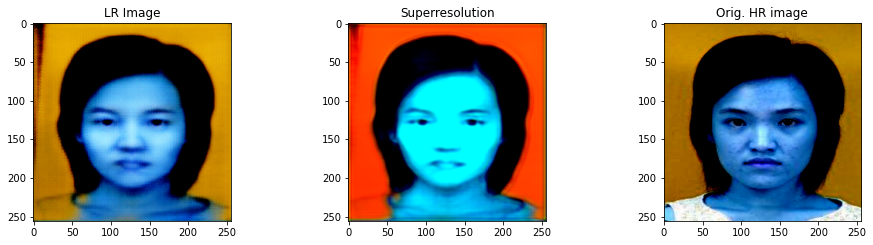

In [ ]:
# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

'''# scale all pixels from [-1,1] to [0,1]
src_image = (src_image + 1) / 2.0
tar_image = (tar_image + 1) / 2.0
gen_image = (gen_image + 1) / 2.0'''

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
def generate_predicted_images(lr_img):
    gen_hr_photos=[]
    for i in range(0,len(lr_img)):
        gen_hr_image = model.predict(lr_img[[i]])
        gen_hr_photos.append(np.array(gen_hr_image))
        
    gen_hr_photos=np.asarray(gen_hr_photos)
    return gen_hr_photos
    

In [ ]:
gen_hr_images=generate_predicted_images(lr_test)

1/1 [==============================] - 0s 248ms/step


In [ ]:
gen_photos=gen_hr_images
real_photos=hr_test
gen_photos.shape

(88, 1, 256, 256, 3)

In [ ]:
gen_photos.resize((88, 256, 256, 3),refcheck=False)

In [ ]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import matplotlib.pyplot as pyplot

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load cifar10 images
images1=real_photos 
images2 = gen_photos

print('Loaded', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

Loaded (88, 256, 256, 3) (88, 256, 256, 3)
Scaled (88, 299, 299, 3) (88, 299, 299, 3)
3/3 [==============================] - 9s 3s/step
FID: 25.872


In [ ]:
from skimage import metrics
from skimage import measure
import skimage


In [ ]:
mean=0
psnr=0
rmse=0
for i in range(len(gen_photos)):
  ref_img = real_photos [i]
  img = gen_photos [i]
  mse_skimg = metrics.mean_squared_error(ref_img, img)
  psnr_skimg =metrics.peak_signal_noise_ratio(ref_img, img, data_range=None)
  rmse_skimg =metrics.normalized_root_mse(ref_img, img)
  mean+=mse_skimg
  psnr+=psnr_skimg
  rmse+=rmse_skimg
mean =mean/len(gen_photos)
rmse= rmse/len(gen_photos)
psnr=psnr/len(gen_photos)
len(gen_photos)


88

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim 
s=0
for i in range(len(gen_photos)):
  s+= ssim(real_photos[i].astype(float),gen_photos[i].astype(float), multichannel = True)

s=s/len(gen_photos)
print(s)

C:\Users\Dell\AppData\Local\Temp\ipykernel_6496\3708616001.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  s+= ssim(real_photos[i].astype(float),gen_photos[i].astype(float), multichannel = True)


0.3026118895551261


In [ ]:
print(mean)

0.19084369242646607


In [ ]:
print(psnr)

13.429123579883871


In [ ]:
print(rmse)

0.724910846315743
